In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from google.colab import drive

In [3]:
def mount_drive():
    drive.mount('/content/drive')
    print("Google Drive mounted.")

In [4]:
EMOTIONS = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
NUM_CLASSES = len(EMOTIONS)
IMAGE_SIZE = 48  #FER-2013 images are 48x48 pixels
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 20

DATA_PATH = '/content/drive/MyDrive/445/fer2013'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TEST_PATH = os.path.join(DATA_PATH, 'test')

In [5]:
class FERDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = []
        for cls_name in self.classes:
            cls_dir = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                self.samples.append((img_path, self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('L')  #convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
def get_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    return train_transform, test_transform

In [7]:
def create_data_loaders(train_path, test_path, batch_size):
    train_transform, test_transform = get_transforms()

    train_dataset = FERDataset(train_path, transform=train_transform)
    test_dataset = FERDataset(test_path, transform=test_transform)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Testing samples: {len(test_dataset)}")

    train_counts = {}
    for _, label in train_dataset.samples:
        emotion = EMOTIONS[label]
        train_counts[emotion] = train_counts.get(emotion, 0) + 1

    print("\nTrain class distribution:")
    for emotion, count in train_counts.items():
        print(f"{emotion}: {count} ({count/len(train_dataset)*100:.2f}%)")

    test_counts = {}
    for _, label in test_dataset.samples:
        emotion = EMOTIONS[label]
        test_counts[emotion] = test_counts.get(emotion, 0) + 1

    print("\nTest class distribution:")
    for emotion, count in test_counts.items():
        print(f"{emotion}: {count} ({count/len(test_dataset)*100:.2f}%)")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

In [8]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()

        #1st convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        #2nd convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        #3rd convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        #4th convolutional block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        #input: 48x48 -> After 4 max pooling with stride 2: 3x3
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        #first block
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        #2nd
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        #3rdblovk
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        #fourth block
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        x = x.view(x.size(0), -1)

        #fully connected layers
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = self.fc2(x)

        return x

In [9]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc="Training")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar.set_postfix({
            'loss': running_loss / (progress_bar.n + 1),
            'acc': 100. * correct / total
        })

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    return train_loss, train_acc

In [10]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    class_correct = list(0. for i in range(NUM_CLASSES))
    class_total = list(0. for i in range(NUM_CLASSES))

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Evaluating")
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            c = (predicted == targets).squeeze()
            for i in range(targets.size(0)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

            progress_bar.set_postfix({
                'loss': running_loss / (progress_bar.n + 1),
                'acc': 100. * correct / total
            })

    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total

    print("\nPer-class accuracy:")
    for i in range(NUM_CLASSES):
        if class_total[i] > 0:
            print(f'{EMOTIONS[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

    return test_loss, test_acc

In [11]:
def visualize_samples(data_loader, class_names, num_samples=8):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)

    plt.figure(figsize=(15, 8))
    for i in range(num_samples):
        plt.subplot(2, num_samples//2, i+1)
        img = images[i].squeeze().numpy()
        img = (img * 0.5 + 0.5)  #denormalize
        plt.imshow(img, cmap='gray')
        plt.title(class_names[labels[i].item()])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, test_loader, class_names, device):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Computing confusion matrix"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    #compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    #normalize confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return cm, cm_norm

In [12]:
def save_model(model, path='/content/drive/MyDrive/445/best_emotion_model.pth'):
    """Save the model to Google Drive"""
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def save_figure(figure_path='/content/drive/MyDrive/445/training_history.png'):
    """Save the training history figure to Google Drive"""
    plt.savefig(figure_path)
    print(f"Figure saved to {figure_path}")

In [13]:
def main():
    drive.mount('/content/drive')
    zip_path = '/content/drive/MyDrive/445/fer-2013.zip'
    dataset_dir = '/content/fer2013_dataset'
    os.makedirs(dataset_dir, exist_ok=True)

    print(f"Extracting {zip_path} to {dataset_dir}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

    train_path = os.path.join(dataset_dir, 'train')
    test_path = os.path.join(dataset_dir, 'test')

    if not os.path.exists(train_path) or not os.path.exists(test_path):
        print(f"Warning: Could not find expected directories. Available contents: {os.listdir(dataset_dir)}")
        for item in os.listdir(dataset_dir):
            item_path = os.path.join(dataset_dir, item)
            if os.path.isdir(item_path):
                if 'train' in os.listdir(item_path) and 'test' in os.listdir(item_path):
                    train_path = os.path.join(item_path, 'train')
                    test_path = os.path.join(item_path, 'test')
                    break

    print(f"Train path: {train_path}")
    print(f"Test path: {test_path}")

    train_loader, test_loader = create_data_loaders(train_path, test_path, BATCH_SIZE)

    class_names = list(EMOTIONS.values())
    visualize_samples(train_loader, class_names)

    model = EmotionCNN(num_classes=NUM_CLASSES).to(device)
    print(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)

        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)

        #learning rate
        scheduler.step(test_loss)

        #save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        #save the best model
        if test_acc > best_acc:
            print(f"New best accuracy: {test_acc:.2f}% (previous: {best_acc:.2f}%)")
            best_acc = test_acc
            save_model(model, '/content/drive/MyDrive/445/best_emotion_model.pth')

        print(f"Epoch {epoch+1}/{EPOCHS} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    #plott training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['test_acc'], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Curves')

    plt.tight_layout()
    save_figure('/content/drive/MyDrive/445/training_history.png')
    plt.show()

    #confusion matrix
    plot_confusion_matrix(model, test_loader, class_names, device)

    print(f"Best test accuracy: {best_acc:.2f}%")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting /content/drive/MyDrive/445/fer-2013.zip to /content/fer2013_dataset
Train path: /content/fer2013_dataset/train
Test path: /content/fer2013_dataset/test
Training samples: 28709
Testing samples: 7178

Train class distribution:
Angry: 3171 (11.05%)
Disgust: 3995 (13.92%)
Fear: 7215 (25.13%)
Happy: 4097 (14.27%)
Sad: 4965 (17.29%)
Surprise: 436 (1.52%)
Neutral: 4830 (16.82%)

Test class distribution:
Angry: 831 (11.58%)
Disgust: 958 (13.35%)
Fear: 1774 (24.71%)
Happy: 1024 (14.27%)
Sad: 1233 (17.18%)
Surprise: 111 (1.55%)
Neutral: 1247 (17.37%)


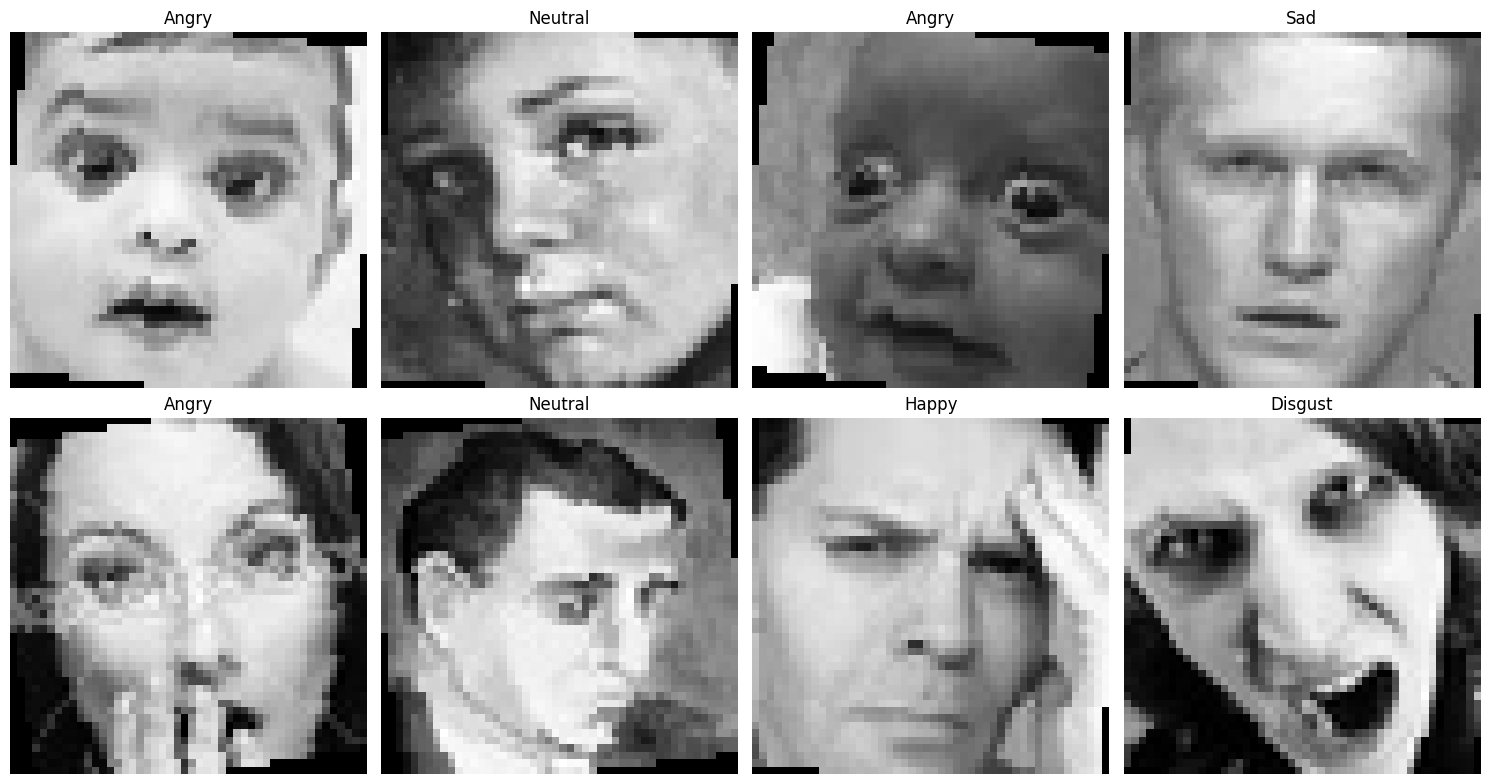

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


EmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

Evaluating: 100%|██████████| 113/113 [00:03<00:00, 35.27it/s, loss=1.5, acc=42.4]



Per-class accuracy:
Angry: 56.08%
Disgust: 0.31%
Fear: 89.52%
Happy: 4.30%
Sad: 61.39%
Surprise: 0.00%
Neutral: 14.92%
New best accuracy: 42.41% (previous: 0.00%)
Model saved to /content/drive/MyDrive/445/best_emotion_model.pth
Epoch 1/20 - Train Loss: 1.6648, Train Acc: 33.62%, Test Loss: 1.4565, Test Acc: 42.41%

Epoch 2/20


Evaluating: 100%|██████████| 113/113 [00:03<00:00, 37.22it/s, loss=1.32, acc=49.1]



Per-class accuracy:
Angry: 67.27%
Disgust: 19.73%
Fear: 87.99%
Happy: 1.76%
Sad: 59.37%
Surprise: 0.00%
Neutral: 37.05%
New best accuracy: 49.05% (previous: 42.41%)
Model saved to /content/drive/MyDrive/445/best_emotion_model.pth
Epoch 2/20 - Train Loss: 1.4196, Train Acc: 45.50%, Test Loss: 1.3202, Test Acc: 49.05%

Epoch 3/20


Evaluating: 100%|██████████| 113/113 [00:03<00:00, 29.60it/s, loss=1.25, acc=51.9]



Per-class accuracy:
Angry: 84.48%
Disgust: 33.72%
Fear: 84.78%
Happy: 8.30%
Sad: 59.21%
Surprise: 0.00%
Neutral: 30.79%
New best accuracy: 51.94% (previous: 49.05%)
Model saved to /content/drive/MyDrive/445/best_emotion_model.pth
Epoch 3/20 - Train Loss: 1.3395, Train Acc: 48.36%, Test Loss: 1.2346, Test Acc: 51.94%

Epoch 4/20


Evaluating: 100%|██████████| 113/113 [00:03<00:00, 37.04it/s, loss=1.18, acc=53.6]



Per-class accuracy:
Angry: 74.49%
Disgust: 22.34%
Fear: 83.26%
Happy: 14.36%
Sad: 62.77%
Surprise: 0.00%
Neutral: 49.32%
New best accuracy: 53.58% (previous: 51.94%)
Model saved to /content/drive/MyDrive/445/best_emotion_model.pth
Epoch 4/20 - Train Loss: 1.2916, Train Acc: 50.55%, Test Loss: 1.1820, Test Acc: 53.58%

Epoch 5/20


Evaluating: 100%|██████████| 113/113 [00:03<00:00, 28.42it/s, loss=1.19, acc=55.5]



Per-class accuracy:
Angry: 63.42%
Disgust: 37.58%
Fear: 82.98%
Happy: 13.57%
Sad: 52.07%
Surprise: 0.00%
Neutral: 67.92%
New best accuracy: 55.54% (previous: 53.58%)
Model saved to /content/drive/MyDrive/445/best_emotion_model.pth
Epoch 5/20 - Train Loss: 1.2379, Train Acc: 52.90%, Test Loss: 1.1631, Test Acc: 55.54%

Epoch 6/20


Evaluating: 100%|██████████| 113/113 [00:03<00:00, 37.62it/s, loss=1.16, acc=56.3]



Per-class accuracy:
Angry: 68.83%
Disgust: 33.30%
Fear: 81.45%
Happy: 21.09%
Sad: 62.85%
Surprise: 0.00%
Neutral: 57.50%
New best accuracy: 56.34% (previous: 55.54%)
Model saved to /content/drive/MyDrive/445/best_emotion_model.pth
Epoch 6/20 - Train Loss: 1.2082, Train Acc: 54.16%, Test Loss: 1.1335, Test Acc: 56.34%

Epoch 7/20


Evaluating: 100%|██████████| 113/113 [00:03<00:00, 37.37it/s, loss=1.14, acc=57.2]



Per-class accuracy:
Angry: 74.49%
Disgust: 52.92%
Fear: 82.02%
Happy: 25.10%
Sad: 52.39%
Surprise: 0.00%
Neutral: 49.72%
New best accuracy: 57.17% (previous: 56.34%)
Model saved to /content/drive/MyDrive/445/best_emotion_model.pth
Epoch 7/20 - Train Loss: 1.1812, Train Acc: 55.17%, Test Loss: 1.1236, Test Acc: 57.17%

Epoch 8/20


Evaluating: 100%|██████████| 113/113 [00:03<00:00, 32.90it/s, loss=1.1, acc=58.6]



Per-class accuracy:
Angry: 80.63%
Disgust: 56.05%
Fear: 81.96%
Happy: 26.17%
Sad: 54.42%
Surprise: 0.00%
Neutral: 48.76%
New best accuracy: 58.62% (previous: 57.17%)
Model saved to /content/drive/MyDrive/445/best_emotion_model.pth
Epoch 8/20 - Train Loss: 1.1564, Train Acc: 56.62%, Test Loss: 1.0914, Test Acc: 58.62%

Epoch 9/20


Evaluating: 100%|██████████| 113/113 [00:03<00:00, 37.30it/s, loss=1.11, acc=58.8]



Per-class accuracy:
Angry: 76.77%
Disgust: 38.10%
Fear: 84.39%
Happy: 20.51%
Sad: 71.78%
Surprise: 0.00%
Neutral: 50.20%
New best accuracy: 58.80% (previous: 58.62%)
Model saved to /content/drive/MyDrive/445/best_emotion_model.pth
Epoch 9/20 - Train Loss: 1.1399, Train Acc: 57.10%, Test Loss: 1.0823, Test Acc: 58.80%

Epoch 10/20


Evaluating: 100%|██████████| 113/113 [00:04<00:00, 25.30it/s, loss=1.13, acc=58.1]



Per-class accuracy:
Angry: 80.02%
Disgust: 36.95%
Fear: 88.61%
Happy: 22.27%
Sad: 56.93%
Surprise: 0.00%
Neutral: 51.88%
Epoch 10/20 - Train Loss: 1.1175, Train Acc: 57.61%, Test Loss: 1.0984, Test Acc: 58.07%

Epoch 11/20


Evaluating: 100%|██████████| 113/113 [00:02<00:00, 38.14it/s, loss=1.06, acc=60]



Per-class accuracy:
Angry: 72.32%
Disgust: 58.66%
Fear: 81.62%
Happy: 21.68%
Sad: 55.88%
Surprise: 0.00%
Neutral: 62.87%
New best accuracy: 59.99% (previous: 58.80%)
Model saved to /content/drive/MyDrive/445/best_emotion_model.pth
Epoch 11/20 - Train Loss: 1.0974, Train Acc: 58.96%, Test Loss: 1.0538, Test Acc: 59.99%

Epoch 12/20


Evaluating: 100%|██████████| 113/113 [00:03<00:00, 31.93it/s, loss=1.08, acc=60.2]



Per-class accuracy:
Angry: 79.06%
Disgust: 61.48%
Fear: 87.71%
Happy: 23.63%
Sad: 59.12%
Surprise: 0.00%
Neutral: 44.11%
New best accuracy: 60.23% (previous: 59.99%)
Model saved to /content/drive/MyDrive/445/best_emotion_model.pth
Epoch 12/20 - Train Loss: 1.0731, Train Acc: 59.61%, Test Loss: 1.0601, Test Acc: 60.23%

Epoch 13/20


Evaluating: 100%|██████████| 113/113 [00:03<00:00, 36.74it/s, loss=1.05, acc=60.7]



Per-class accuracy:
Angry: 76.05%
Disgust: 51.67%
Fear: 84.05%
Happy: 25.00%
Sad: 64.80%
Surprise: 0.00%
Neutral: 54.61%
New best accuracy: 60.66% (previous: 60.23%)
Model saved to /content/drive/MyDrive/445/best_emotion_model.pth
Epoch 13/20 - Train Loss: 1.0542, Train Acc: 60.44%, Test Loss: 1.0344, Test Acc: 60.66%

Epoch 14/20


Evaluating: 100%|██████████| 113/113 [00:03<00:00, 36.80it/s, loss=1.08, acc=60.8]



Per-class accuracy:
Angry: 78.58%
Disgust: 55.01%
Fear: 89.74%
Happy: 13.48%
Sad: 69.83%
Surprise: 0.00%
Neutral: 47.39%
New best accuracy: 60.77% (previous: 60.66%)
Model saved to /content/drive/MyDrive/445/best_emotion_model.pth
Epoch 14/20 - Train Loss: 1.0300, Train Acc: 61.38%, Test Loss: 1.0658, Test Acc: 60.77%

Epoch 15/20


Evaluating: 100%|██████████| 113/113 [00:03<00:00, 28.26it/s, loss=1.06, acc=60.9]



Per-class accuracy:
Angry: 67.75%
Disgust: 50.42%
Fear: 84.67%
Happy: 23.63%
Sad: 68.21%
Surprise: 0.00%
Neutral: 59.18%
New best accuracy: 60.87% (previous: 60.77%)
Model saved to /content/drive/MyDrive/445/best_emotion_model.pth
Epoch 15/20 - Train Loss: 1.0154, Train Acc: 61.99%, Test Loss: 1.0579, Test Acc: 60.87%

Epoch 16/20


Evaluating: 100%|██████████| 113/113 [00:03<00:00, 37.66it/s, loss=1.08, acc=60.6]



Per-class accuracy:
Angry: 80.75%
Disgust: 46.24%
Fear: 88.50%
Happy: 33.30%
Sad: 54.83%
Surprise: 0.00%
Neutral: 52.29%
Epoch 16/20 - Train Loss: 1.0030, Train Acc: 62.29%, Test Loss: 1.0526, Test Acc: 60.64%

Epoch 17/20


Evaluating: 100%|██████████| 113/113 [00:03<00:00, 29.22it/s, loss=1.03, acc=62]



Per-class accuracy:
Angry: 76.05%
Disgust: 52.61%
Fear: 85.23%
Happy: 24.12%
Sad: 69.83%
Surprise: 6.31%
Neutral: 55.09%
New best accuracy: 61.99% (previous: 60.87%)
Model saved to /content/drive/MyDrive/445/best_emotion_model.pth
Epoch 17/20 - Train Loss: 0.9797, Train Acc: 63.59%, Test Loss: 1.0320, Test Acc: 61.99%

Epoch 18/20


Evaluating: 100%|██████████| 113/113 [00:03<00:00, 36.88it/s, loss=1.03, acc=62.1]



Per-class accuracy:
Angry: 75.93%
Disgust: 52.71%
Fear: 86.36%
Happy: 36.82%
Sad: 62.94%
Surprise: 0.00%
Neutral: 50.92%
New best accuracy: 62.08% (previous: 61.99%)
Model saved to /content/drive/MyDrive/445/best_emotion_model.pth
Epoch 18/20 - Train Loss: 0.9584, Train Acc: 64.29%, Test Loss: 1.0264, Test Acc: 62.08%

Epoch 19/20


Evaluating: 100%|██████████| 113/113 [00:03<00:00, 36.38it/s, loss=1.05, acc=61.2]



Per-class accuracy:
Angry: 71.60%
Disgust: 57.52%
Fear: 87.20%
Happy: 24.90%
Sad: 51.58%
Surprise: 5.41%
Neutral: 64.23%
Epoch 19/20 - Train Loss: 0.9421, Train Acc: 64.95%, Test Loss: 1.0316, Test Acc: 61.17%

Epoch 20/20


Evaluating: 100%|██████████| 113/113 [00:03<00:00, 32.10it/s, loss=1.06, acc=62.3]



Per-class accuracy:
Angry: 80.99%
Disgust: 57.20%
Fear: 87.60%
Happy: 32.71%
Sad: 59.69%
Surprise: 7.21%
Neutral: 49.80%
New best accuracy: 62.34% (previous: 62.08%)
Model saved to /content/drive/MyDrive/445/best_emotion_model.pth
Epoch 20/20 - Train Loss: 0.9309, Train Acc: 65.39%, Test Loss: 1.0363, Test Acc: 62.34%
Figure saved to /content/drive/MyDrive/445/training_history.png


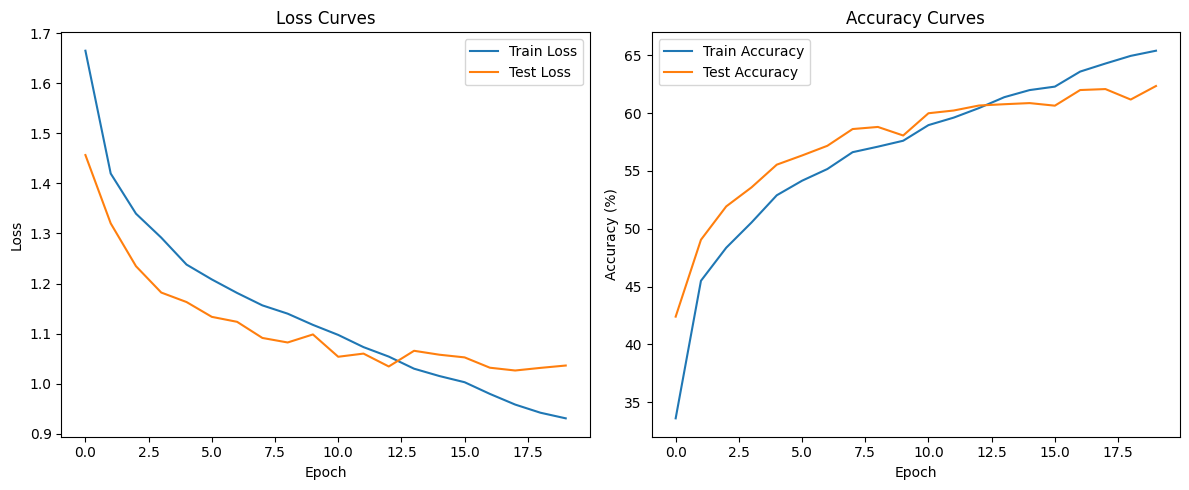

Computing confusion matrix: 100%|██████████| 113/113 [00:02<00:00, 46.59it/s]


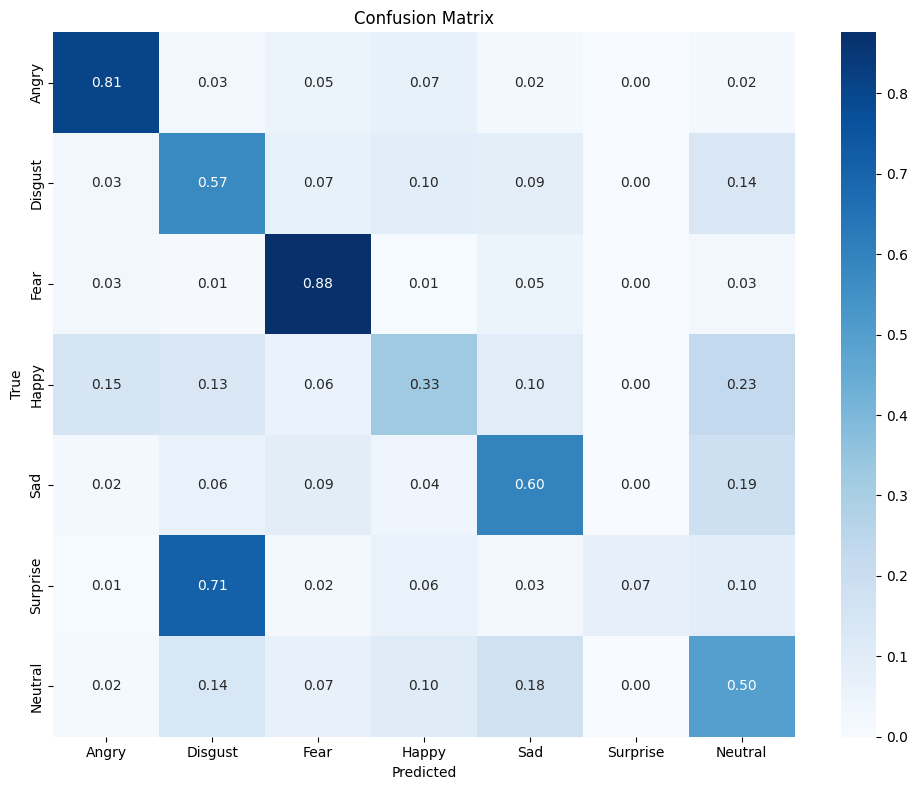

Best test accuracy: 62.34%


In [15]:
import zipfile
if __name__ == "__main__":
    main()

In [16]:
def predict_emotion(image_path):
    #load the model
    model = EmotionCNN(num_classes=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load('/content/drive/MyDrive/445/best_emotion_model.pth'))
    model.eval()

    #preprocess the image
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    #loading and transforming
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0).to(device)

    #making the prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    #get the predicted emotion
    emotion_id = predicted.item()
    emotion_name = EMOTIONS[emotion_id]
    confidence = probabilities[0][emotion_id].item() * 100

    print(f"Predicted emotion: {emotion_name} with {confidence:.2f}% confidence")

    #top 3 predictions
    top_k = 3
    top_prob, top_class = torch.topk(probabilities, top_k, dim=1)

    print("\nTop 3 predictions:")
    for i in range(top_k):
        emotion_id = top_class[0][i].item()
        emotion_name = EMOTIONS[emotion_id]
        confidence = top_prob[0][i].item() * 100
        print(f"{emotion_name}: {confidence:.2f}%")

    #display the image wit prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted: {emotion_name} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    return emotion_name, confidence

In [17]:
def test_on_samples(test_dir, num_samples=5):
    #get random samples from each emotion class
    results = []

    for emotion_folder in os.listdir(test_dir):
        emotion_path = os.path.join(test_dir, emotion_folder)
        if os.path.isdir(emotion_path):
            image_files = os.listdir(emotion_path)
            selected_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)

            for file in selected_files:
                image_path = os.path.join(emotion_path, file)
                true_emotion = emotion_folder
                pred_emotion, confidence = predict_emotion(image_path)

                results.append({
                    'image_path': image_path,
                    'true_emotion': true_emotion,
                    'predicted_emotion': pred_emotion,
                    'confidence': confidence,
                    'correct': true_emotion == pred_emotion
                })

    accuracy = sum(1 for r in results if r['correct']) / len(results) if results else 0
    print(f"\nOverall accuracy on sample test: {accuracy * 100:.2f}%")

    return results

Testing model on image: /content/drive/MyDrive/445/rds.jpg
Predicted emotion: Neutral with 31.24% confidence

Top 3 predictions:
Neutral: 31.24%
Disgust: 26.78%
Happy: 23.89%


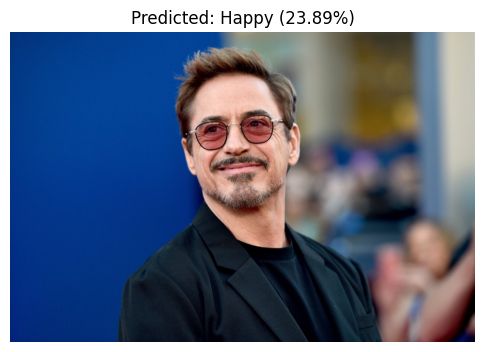

In [18]:
image_path = '/content/drive/MyDrive/445/rds.jpg'

if os.path.exists(image_path):
    print(f"Testing model on image: {image_path}")
    predict_emotion(image_path)
else:
    print(f"Image not found at {image_path}")

Testing model on image: /content/drive/MyDrive/445/rdj1.jpg
Predicted emotion: Neutral with 31.75% confidence

Top 3 predictions:
Neutral: 31.75%
Happy: 30.45%
Sad: 24.82%


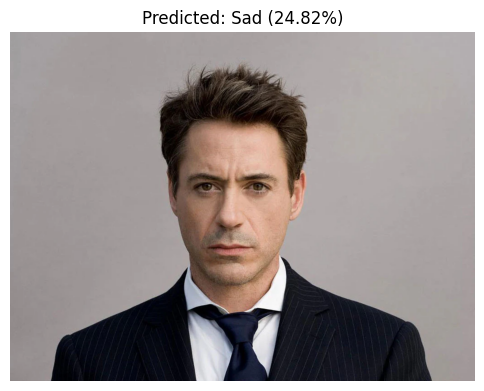

In [19]:
image_path = '/content/drive/MyDrive/445/rdj1.jpg'

if os.path.exists(image_path):
    print(f"Testing model on image: {image_path}")
    predict_emotion(image_path)
else:
    print(f"Image not found at {image_path}")

Testing model on image: /content/drive/MyDrive/445/clown.jpg
Predicted emotion: Fear with 23.56% confidence

Top 3 predictions:
Fear: 23.56%
Sad: 21.44%
Happy: 17.82%


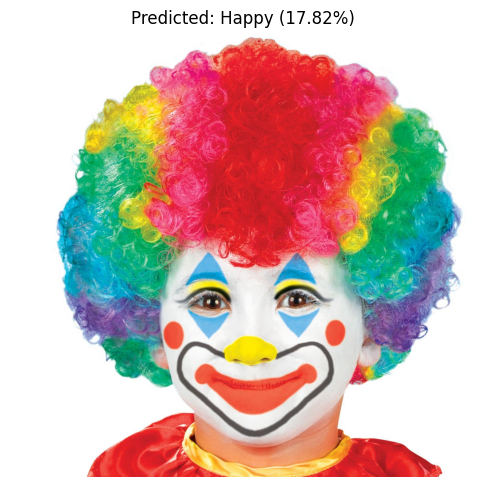

In [20]:
#image path on drive
image_path = '/content/drive/MyDrive/445/clown.jpg'

if os.path.exists(image_path):
    print(f"Testing model on image: {image_path}")
    predict_emotion(image_path)
else:
    print(f"Image not found at {image_path}")